# Your work here!

In [2]:
import numpy as np 
import pandas as pd

import torch, torch.nn as nn, time
from torch.utils.data import Dataset, DataLoader
!pwd
N = 96 
FIRSTRUN = False
TUNE = 20
OFIT = 1000 

/home/irina/Hackathon/environmental-hackathon


In [3]:
train_red = np.load("data/train_data_reduced.npy")
train_red.shape

(20007, 960)

In [4]:
test_red = np.load("data/test_data_reduced.npy")
test_red.shape

(9898, 960)

In [5]:
model = nn.Sequential (
    nn.Linear(N    , N//2 ), nn.ReLU(),
    nn.Linear(N//2 , N//4 ), nn.ReLU(),
    nn.Linear(N//4 , N//8 ), nn.ReLU(),
    nn.Linear(N//8 , N//16), nn.ReLU(),
    nn.Linear(N//16, N//8 ), nn.ReLU(),
    nn.Linear(N//8 , N//4 ), nn.ReLU(),
    nn.Linear(N//4 , N//2 ), nn.ReLU(),
    nn.Linear(N//2 , N    )          )

In [44]:
from nnViz_pytorch import *
import matplotlib.pylab as plt
plt.style.use(['Solarize_Light2'])
%matplotlib inline

plt.rcParams['figure.figsize'] = [10, 13]
plt.rcParams['figure.subplot.left'] = plt.rcParams['figure.subplot.bottom'] = .1
plt.rcParams['figure.subplot.right'] = plt.rcParams['figure.subplot.top'] = .9

1
12240


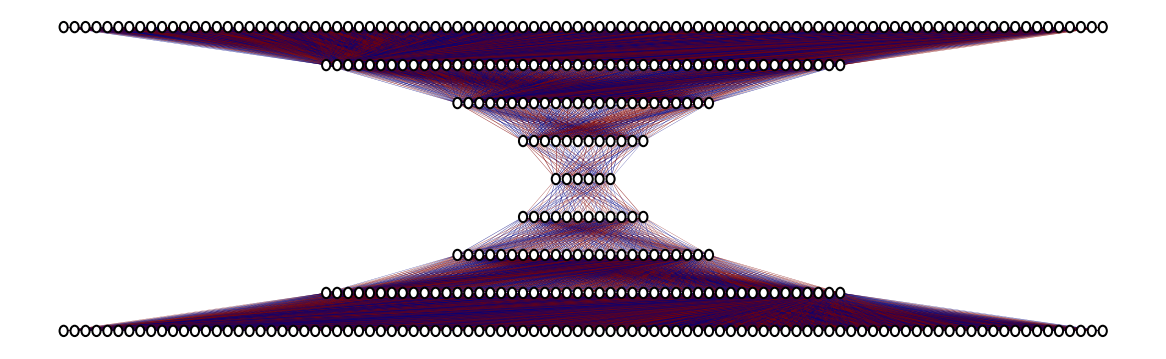

In [45]:
plt.figure(figsize=(20,6));
ax = plt.gca()
visualize_model(model, ax)
plt.axis('tight'); plt.axis('off'); plt.show()


In [46]:
CPU = torch.device('cpu')
GPU = torch.device('cuda:0') 

In [47]:
def train_model ( model, dataLoader, nEpochs = 10):
    model = model.to( GPU )
    lossFunction = nn.MSELoss()
    optimizer = torch.optim.Adam( model.parameters() )
    lossHistory = []
   
    for iEpoch in range(nEpochs):   
        cumulativeLoss = 0
        for i, iInputBatch in enumerate( dataLoader ):
       #     print(iEpoch, i, iInputBatch.shape, iInputBatch[0,20])
            # move batch data to target training device [ cpu or gpu ]
            iInputBatch = iInputBatch.to( GPU )
            
            # zero/reset the parameter gradient buffers to avoid accumulation [ usually accumulation is necessary for temporally unrolled networks ]
            optimizer.zero_grad()

            # generate predictions/reconstructions
            predictions = model.forward(iInputBatch)

            # compute error 
            loss = lossFunction( predictions, iInputBatch )
            cumulativeLoss += loss.item() # gets scaler value held in the loss tensor
            
            # compute gradients by propagating the error backward through the model/graph
            loss.backward()

            # apply gradients to update model parameters
            optimizer.step()
            
       # print( 'epoch {} of {} -- avg batch loss: {}'.format(iEpoch, nEpochs, cumulativeLoss))
        
        lossHistory += [cumulativeLoss]
    return model, lossHistory

In [48]:
def evaluate_model (model, dataLoader, nEvals = 1000):
    mse_errors = []
    test_iterator = iter(dataLoader)
    for iSample in range(nEvals):
        try:
            sample = next(test_iterator)[0]
        except StopIteration:
            test_iterator = iter(dataLoader) # create an object of class _DataLoaderIter
            sample = next(test_iterator)[0]

        reconstruction = model.forward(sample.to(GPU))
        
        sampleNumpy = sample.numpy()
        reconstructionNumpy = reconstruction.data.cpu().numpy()
        mse = (np.square(reconstructionNumpy - sampleNumpy)).mean(axis=None)
        mse_errors.append(mse) 
    return mse_errors            

In [49]:
train_co2 = train_red[:, :N]
test_co2  =  test_red[:, :N]

DL_Train_co2   = DataLoader(train_co2.astype('float32'), batch_size=16, shuffle = True )
DL_Test_co2    = DataLoader( test_co2.astype('float32'), batch_size=1 , shuffle = False)
DL_Train_co2_2 = DataLoader( test_co2.astype('float32'), batch_size=16, shuffle = True )

#startTime = time.time()
if FIRSTRUN: 
    model_co2, loss_co2 = train_model( model, DL_Train_co2, 20)
else:
    model_co2 = torch.load("model_co2.v2.pth", map_location=GPU)
    
model_co2, loss_co2 = train_model( model_co2, DL_Train_co2,   OFIT)
model_co2, loss_co2 = train_model( model_co2, DL_Train_co2_2, TUNE)
#print('elapsed time : {} '.format(time.time() - startTime))
torch.save( model_co2, "model_co2.v2.pth")
torch.cuda.empty_cache()

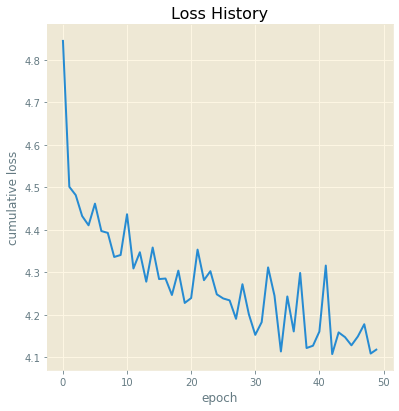

In [50]:
plt.figure(figsize=(6,6));
plt.plot(loss_co2)
plt.title('Loss History'); plt.xlabel('epoch'); plt.ylabel('cumulative loss');

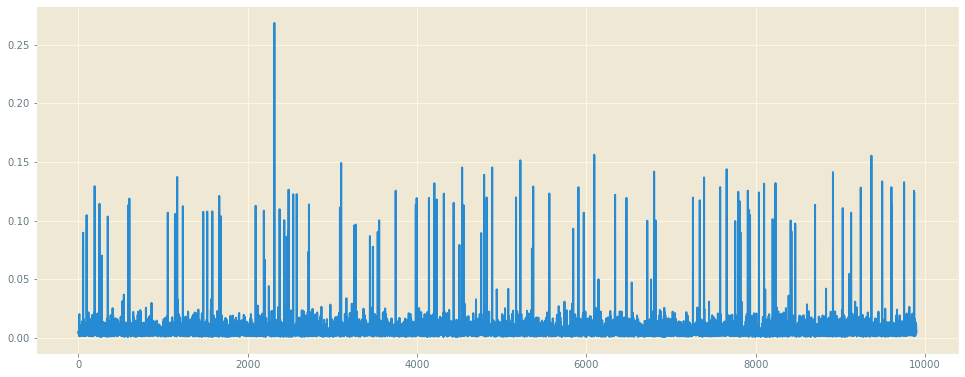

In [52]:
mse_errors_co2 = evaluate_model( model_co2, DL_Test_co2, len(test_red))
plt.figure(figsize=(16,6));
plt.plot(mse_errors_co2);

In [56]:
train_tem = train_red[:, N: N*2]
test_tem  =  test_red[:, N: N*2]
DL_Train_tem  = DataLoader(train_tem.astype('float32'), batch_size=16, shuffle = True )
DL_Test_tem   = DataLoader( test_tem.astype('float32'), batch_size=1 , shuffle = False)
DL_Train_tem2 = DataLoader( test_tem.astype('float32'), batch_size=16, shuffle = True )

if FIRSTRUN: 
    model_tem, loss_tem = train_model( model, DL_Train_tem, 20)
else:
    model_tem = torch.load("model_tem.v2.pth", map_location=GPU)
model_tem, loss_tem = train_model( model_tem, DL_Train_tem,  OFIT)
model_tem, loss_tem = train_model( model_tem, DL_Train_tem2, TUNE) 
torch.save( model_tem, "model_tem.v2.pth")
torch.cuda.empty_cache()

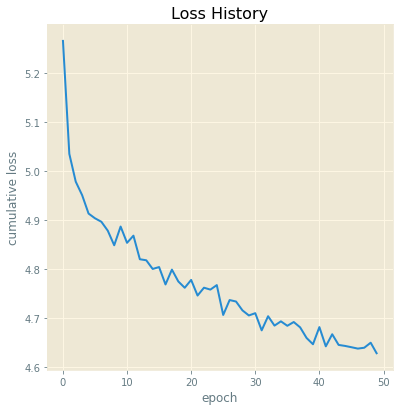

In [57]:
plt.figure(figsize=(6,6));
plt.plot(loss_tem)
plt.title('Loss History'); plt.xlabel('epoch'); plt.ylabel('cumulative loss');

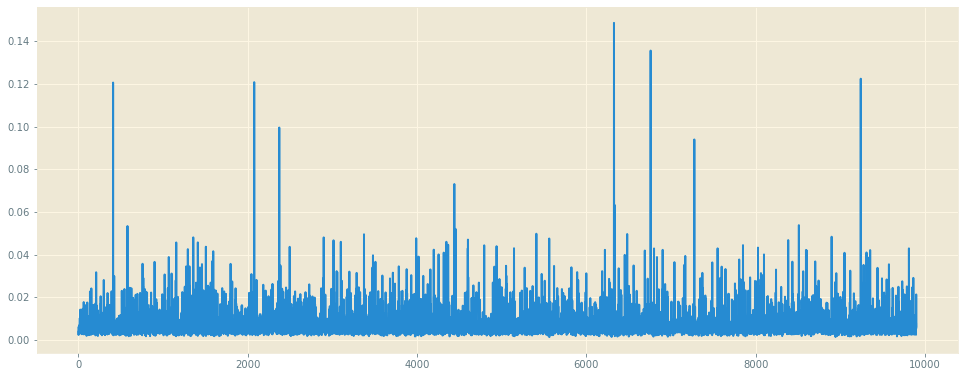

In [58]:
mse_errors_tem = evaluate_model( model_tem, DL_Test_tem, len(test_red))
#print(len(mse_errors_tem))
plt.figure(figsize=(16,6));
plt.plot(mse_errors_tem)

In [60]:
train_dew = train_red[:, N*2: N*3]
test_dew  =  test_red[:, N*2: N*3]
DL_Train_dew  = DataLoader(train_dew.astype('float32'), batch_size=16, shuffle = True )
DL_Test_dew   = DataLoader( test_dew.astype('float32'), batch_size=1 , shuffle = False)
DL_Train_dew2 = DataLoader( test_dew.astype('float32'), batch_size=16, shuffle = True )

if FIRSTRUN: 
    model_dew, loss_dew = train_model( model, DL_Train_dew, 20)
else:
    model_dew = torch.load("model_dew.v2.pth", map_location=GPU)
model_dew, loss_dew = train_model( model_dew, DL_Train_dew,  OFIT)
model_dew, loss_dew = train_model( model_dew, DL_Train_dew2, TUNE) 
torch.save( model_dew, "model_dew.v2.pth")
torch.cuda.empty_cache()

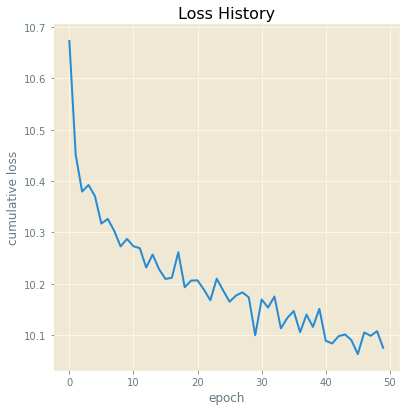

In [61]:
plt.figure(figsize=(6,6));
plt.plot(loss_dew)
plt.title('Loss History'); plt.xlabel('epoch'); plt.ylabel('cumulative loss');


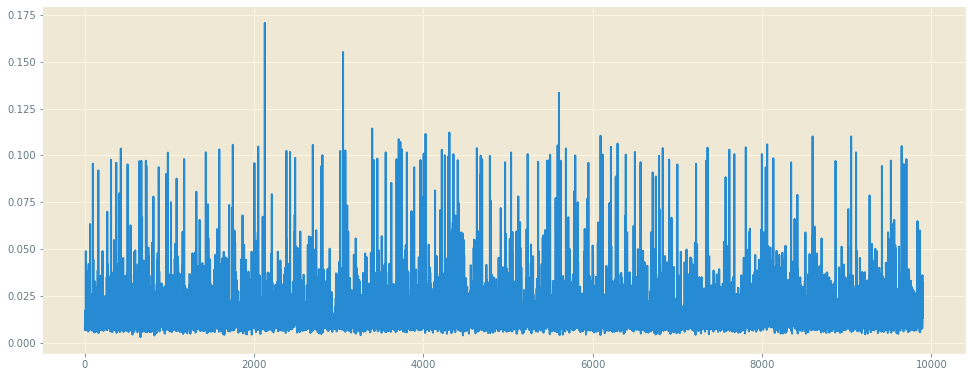

In [62]:
mse_errors_dew = evaluate_model( model_dew, DL_Test_dew, len(test_red))
plt.figure(figsize=(16,6));
plt.plot(mse_errors_dew)

In [64]:
train_hum = train_red[:, N*3: N*4]
test_hum  = test_red[:,  N*3: N*4]
DL_Train_hum  = DataLoader(train_hum.astype('float32'), batch_size=16, shuffle = True )
DL_Test_hum   = DataLoader( test_hum.astype('float32'), batch_size=1 , shuffle = False)
DL_Train_hum2 = DataLoader( test_hum.astype('float32'), batch_size=16, shuffle = True )

if FIRSTRUN:
    model_hum, loss_hum = train_model( model, DL_Train_hum, 20)
else:
    model_hum = torch.load("model_hum.v2.pth", map_location=GPU)
model_hum, loss_hum = train_model( model_hum, DL_Train_hum,  OFIT)
model_hum, loss_hum = train_model( model_hum, DL_Train_hum2, TUNE) 
torch.save( model_hum, "model_hum.v2.pth")
torch.cuda.empty_cache()

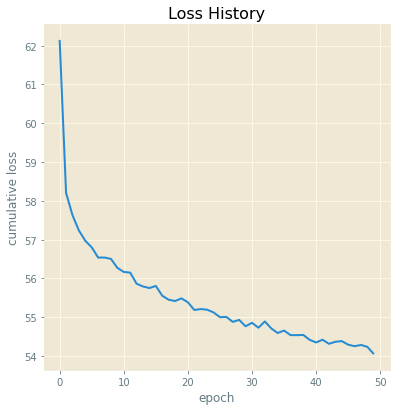

In [65]:
plt.figure(figsize=(6,6));
plt.plot(loss_hum)
plt.title('Loss History'); plt.xlabel('epoch'); plt.ylabel('cumulative loss');


9898


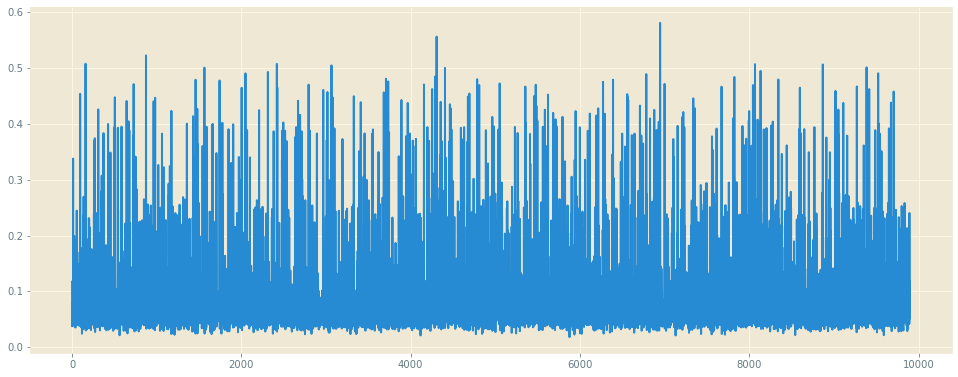

In [66]:
mse_errors_hum = evaluate_model( model_hum, DL_Test_hum, len(test_red))
print(len(mse_errors_hum))
plt.figure(figsize=(16,6));
plt.plot(mse_errors_hum)

In [67]:
#torch.save( model_co2, "model_co2.v2.pth")
#torch.save( model_tem, "model_tem.v2.pth")
#torch.save( model_dew, "model_dew.v2.pth")
#torch.save( model_hum, "model_hum.v2.pth")


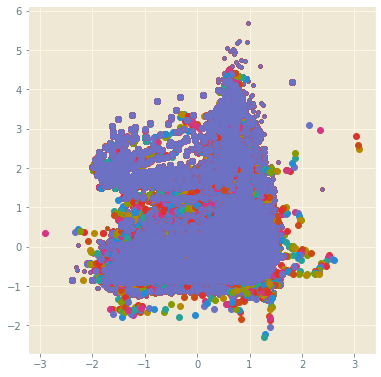

In [68]:
plt.figure(figsize=(6,6))
plt.plot(train_dew, train_co2,'.');
plt.plot(test_dew,  test_co2,'o');


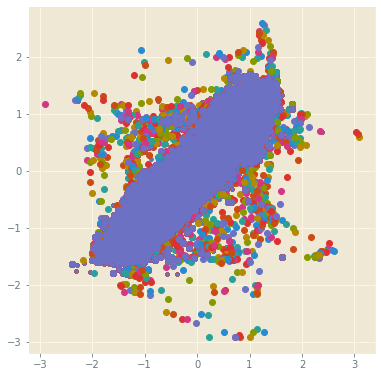

In [69]:
plt.figure(figsize=(6,6))
plt.plot(train_dew, train_tem,'.');
plt.plot(test_dew, test_tem,'o');

In [70]:
def pretty_size(size):
	"""Pretty prints a torch.Size object"""
	assert(isinstance(size, torch.Size))
	return " × ".join(map(str, size))

def dump_tensors(gpu_only=True):
	"""Prints a list of the Tensors being tracked by the garbage collector."""
	import gc
	total_size = 0
	for obj in gc.get_objects():
		try:
			if torch.is_tensor(obj):
				if not gpu_only or obj.is_cuda:
					print("%s:%s%s %s" % (type(obj).__name__, 
										  " GPU" if obj.is_cuda else "",
										  " pinned" if obj.is_pinned else "",
										  pretty_size(obj.size())))
					total_size += obj.numel()
			elif hasattr(obj, "data") and torch.is_tensor(obj.data):
				if not gpu_only or obj.is_cuda:
					print("%s → %s:%s%s%s%s %s" % (type(obj).__name__, 
												   type(obj.data).__name__, 
												   " GPU" if obj.is_cuda else "",
												   " pinned" if obj.data.is_pinned else "",
												   " grad" if obj.requires_grad else "", 
												   " volatile" if obj.volatile else "",
												   pretty_size(obj.data.size())))
					total_size += obj.data.numel()
		except Exception as e:
			pass        
	print("Total size:", total_size)


In [71]:
dump_tensors()

Parameter: GPU pinned 48 × 96
Parameter: GPU pinned 48
Parameter: GPU pinned 24 × 48
Parameter: GPU pinned 24
Parameter: GPU pinned 12 × 24
Parameter: GPU pinned 12
Parameter: GPU pinned 6 × 12
Parameter: GPU pinned 6
Parameter: GPU pinned 12 × 6
Parameter: GPU pinned 12
Parameter: GPU pinned 24 × 12
Parameter: GPU pinned 24
Parameter: GPU pinned 48 × 24
Parameter: GPU pinned 48
Parameter: GPU pinned 96 × 48
Parameter: GPU pinned 96
Parameter: GPU pinned 48 × 96
Parameter: GPU pinned 48
Parameter: GPU pinned 24 × 48
Parameter: GPU pinned 24
Parameter: GPU pinned 12 × 24
Parameter: GPU pinned 12
Parameter: GPU pinned 6 × 12
Parameter: GPU pinned 6
Parameter: GPU pinned 12 × 6
Parameter: GPU pinned 12
Parameter: GPU pinned 24 × 12
Parameter: GPU pinned 24
Parameter: GPU pinned 48 × 24
Parameter: GPU pinned 48
Parameter: GPU pinned 96 × 48
Parameter: GPU pinned 96
Parameter: GPU pinned 48 × 96
Parameter: GPU pinned 48
Parameter: GPU pinned 24 × 48
Parameter: GPU pinned 24
Parameter: GPU p

/home/irina/.local/lib/python3.8/site-packages/torch/distributed/distributed_c10d.py:125: UserWarning: torch.distributed.reduce_op is deprecated, please use torch.distributed.ReduceOp instead
  warnings.warn("torch.distributed.reduce_op is deprecated, please use "


In [72]:
torch.cuda.empty_cache()

In [73]:
dump_tensors()

Parameter: GPU pinned 48 × 96
Parameter: GPU pinned 48
Parameter: GPU pinned 24 × 48
Parameter: GPU pinned 24
Parameter: GPU pinned 12 × 24
Parameter: GPU pinned 12
Parameter: GPU pinned 6 × 12
Parameter: GPU pinned 6
Parameter: GPU pinned 12 × 6
Parameter: GPU pinned 12
Parameter: GPU pinned 24 × 12
Parameter: GPU pinned 24
Parameter: GPU pinned 48 × 24
Parameter: GPU pinned 48
Parameter: GPU pinned 96 × 48
Parameter: GPU pinned 96
Parameter: GPU pinned 48 × 96
Parameter: GPU pinned 48
Parameter: GPU pinned 24 × 48
Parameter: GPU pinned 24
Parameter: GPU pinned 12 × 24
Parameter: GPU pinned 12
Parameter: GPU pinned 6 × 12
Parameter: GPU pinned 6
Parameter: GPU pinned 12 × 6
Parameter: GPU pinned 12
Parameter: GPU pinned 24 × 12
Parameter: GPU pinned 24
Parameter: GPU pinned 48 × 24
Parameter: GPU pinned 48
Parameter: GPU pinned 96 × 48
Parameter: GPU pinned 96
Parameter: GPU pinned 48 × 96
Parameter: GPU pinned 48
Parameter: GPU pinned 24 × 48
Parameter: GPU pinned 24
Parameter: GPU p